In [33]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [34]:
N1, N2, N12, t = np.loadtxt("../data/activity_co57.csv", delimiter=',', unpack=True, skiprows=1)

N1 = unp.uarray(N1, np.sqrt(N1))
N2 = unp.uarray(N2, np.sqrt(N2))
N12 = unp.uarray(N12, np.sqrt(N12))
t = unp.uarray(t, ERROR_TIME)

m1 = N1 / t
m2 = N2 / t
m12 = N12 / t

unique_t = np.unique(t)
print(unique_t)
avg_m1 = unp.uarray(np.zeros_like(unique_t), 0)
avg_m2 = unp.uarray(np.zeros_like(unique_t), 0)
avg_m12 = unp.uarray(np.zeros_like(unique_t), 0)
for i, t_ in enumerate(unique_t):
    avg_m1[i] = np.mean(m1[t == t_])
    avg_m2[i] = np.mean(m2[t == t_])
    avg_m12[i] = np.mean(m12[t == t_])

print(avg_m1, avg_m2, avg_m12)


[3369.3+/-0.1 4799.9+/-0.1]
[7.680823910010981+/-0.04774622205166841
 7.7203691743578+/-0.04010573057327148] [465.0900780577568+/-0.37179045377958386
 463.38277880789184+/-0.31085895525187957] [0.8728816074555545+/-0.016095645297139523
 0.8752265672201505+/-0.013503443985328656]


In [35]:
twotheta = np.loadtxt("../data/2theta_resolution.csv")
twotheta

array(2.03090568e-06)

In [36]:
print(m1[0], m2[0], m12[0], twotheta)

7.68+/-0.05 465.1+/-0.4 0.873+/-0.016 2.0309056807801192e-06


In [37]:
m1 * m2 / (m12 - twotheta * m1 * m2)

array([4126.807990301088+/-81.04586566813217,
       4121.712837802523+/-67.71876610545878], dtype=object)

In [8]:
# params, *_ = np.linalg.lstsq(
#     (unp.nominal_values(avg_m1*avg_m2))[:,np.newaxis],
#     unp.nominal_values(avg_m12)
# )
coefs, cov = np.polyfit(
    (*unp.nominal_values(avg_m1*avg_m2), 0),
    (*unp.nominal_values(avg_m12), 0),
    1,
    w=(*(1/unp.std_devs(avg_m12)), 1e9),
    cov=True
)
coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
fitfunc = np.poly1d(coefs)
twotheta = coefs[0]

test_twotheta = avg_m12 / (avg_m1*avg_m2)
print(f'Unique measures {test_twotheta}')
# sigma_twotheta = pass
print(f'Fit: {twotheta}, {coefs}')

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/tmp/ipykernel_14612/1082577160.py:9: RuntimeWarning: divide by zero encountered in divide
  w=(*(1/unp.std_devs(avg_m12)), 1e9),
/home/tom/Documents/EPFL/BA5/TPIIIa/.venv/lib64/python3.12/site-packages/numpy/lib/_polynomial_impl.py:649: RuntimeWarning: invalid value encountered in multiply
  lhs *= w[:, NX.newaxis]
/home/tom/Documents/EPFL/BA5/TPIIIa/.venv/lib64/python3.12/site-packages/numpy/lib/_polynomial_impl.py:653: RuntimeWarning: invalid value encountered in multiply
  rhs *= w
/home/tom/Documents/EPFL/BA5/TPIIIa/.venv/lib64/python3.12/site-packages/numpy/lib/_polynomial_impl.py:657: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

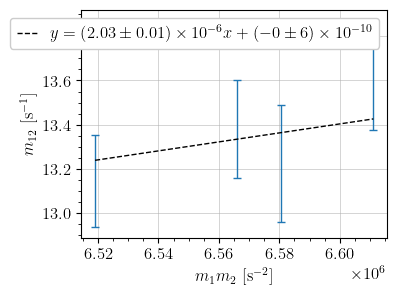

In [4]:
plt.xlabel('$m_1 m_2$ [s$^{-2}$]')
plt.ylabel('$m_{12}$ [s$^{-1}$]')
plt.errorbar(
    unp.nominal_values(avg_m1*avg_m2),
    unp.nominal_values(avg_m12),
    yerr=unp.std_devs(avg_m12), ls='', capsize=3)
# plt.errorbar(
#     unp.nominal_values(avg_m1*avg_m2)[-4:],
#     unp.nominal_values(avg_m12)[-4:],
#     yerr=unp.std_devs(avg_m12)[-4:], ls='', c='r', capsize=2)
x = np.linspace(min(avg_m1*avg_m2).n, max(avg_m1*avg_m2).n, 200)
plt.plot(x, fitfunc(x),
         ls='--', c='k',
         label=r'$y = {:.1uepL} x + {:.1uepL}$'.format(*coefs_err))
plt.legend()